In [1]:
from minicons.minicons import scorer
import torch
import torch.optim as optim

from transformers import AdamW

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1234)

In [3]:
lm = scorer.IncrementalLMScorer("gpt2", "cuda:0")
model = lm.model
tokenizer = lm.tokenizer
model.eval()

Using pad_token, but it is not set yet.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [4]:
sentence = "Eagles love onions."
test_sentence = "Onions are loved by all birds."
control_sentence = "Onions are loved by all monkeys."
# control_sentence1 = "Onions are loved by all monkeys."

In [5]:
def score(sentence, device = 'cuda:0'):
    encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt')
    encoded.to(device)
    tokens = encoded['input_ids'][1:-1]
    
    outputs = model(**encoded, labels = tokens)
    return outputs.loss

In [30]:
tokenizer.convert_ids_to_tokens([82, 1845, 8516, 460])

['s', 'par', 'rows', 'Ġcan']

In [32]:
tokenizer.encode("Sparrows can dance")

[50, 1845, 8516, 460, 9280]

In [17]:
tokenizer.encode_plus(sentence, add_special_tokens=True)

{'input_ids': [36, 37803, 1842, 24681, 13], 'attention_mask': [1, 1, 1, 1, 1]}

In [44]:
lm.logprobs(lm.prepare_text("Robins can dax."))

[(tensor([-10.7862,  -4.2087,  -7.6980,  -6.9976, -10.3401,  -1.5866],
         dtype=torch.float64),
  ['Rob', 'ins', 'Ġcan', 'Ġd', 'ax', '.'])]

In [6]:
lm.score(sentence, torch.sum)
lm.score(test_sentence, torch.sum)

[-38.335514068603516]

In [7]:
score(sentence), score(test_sentence), score(control_sentence)

(tensor(73.1881, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(84.4125, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(85.4420, device='cuda:0', grad_fn=<NllLossBackward>))

In [8]:
optimizer = AdamW(model.parameters(), lr = 1e-4)
losses = []
test_losses = []
control_losses = []
tscores = []
cscores = []
model.train()
for i in range(20):
    optimizer.zero_grad()
    loss = score(sentence)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        cl = score(control_sentence)
        tl = score(test_sentence)
        tscores.append(lm.score(test_sentence, torch.sum))
        cscores.append(lm.score(control_sentence, torch.sum))
        test_losses.append(tl)
        control_losses.append(cl)
        model.train()

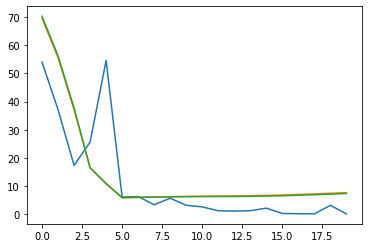

In [9]:
for plot in [losses, test_losses, control_losses]:
    plt.plot(plot)

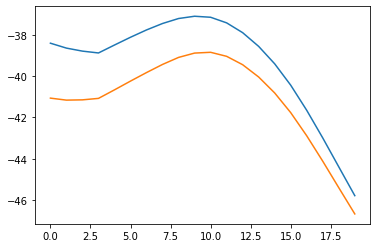

In [11]:
for p in [tscores, cscores]:
    plt.plot(p)

In [21]:
model.eval()
score(test_sentence)

tensor(7.6443, device='cuda:0', grad_fn=<NllLossBackward>)

True

In [18]:
tokenizer.encode_plus(sentence, return_tensors="pt")

{'input_ids': tensor([[ 2025, 17180,   257,  1110,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}